# Choosing the best chemical dosage (IC50) per drug per patient

In [1]:
import pandas as pd
valid_IC50s = pd.read_csv("valid_IC50s_within_range.csv")
merged_df = pd.read_csv("final_merged.csv")

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_3870/1582840386.py:3: DtypeWarning: Columns (0,3,4,5,6,7,9,12,15,16,17,18,22,24,26,28,29,30,40,65,66,67,68,69,70,71,72,73,74,75,76,82,83,89,90,91,92,93,96,97,98,99,100,101,102,103,104,105,106,107,108,109,115) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("final_merged.csv")


In [3]:
valid_IC50s.drop(columns = ['Unnamed: 0', 'N Points'], inplace = True)

In [5]:
import numpy as np

# Get value counts as probabilities
race_dist = merged_df['Race'].value_counts(normalize=True)

# Get the indices where race is missing
missing_indices = merged_df['Race'].isna()

# Sample values based on observed distribution
imputed_values = np.random.choice(race_dist.index, size=missing_indices.sum(), p=race_dist.values)

# Assign the sampled values to the missing positions
merged_df.loc[missing_indices, 'Race'] = imputed_values


In [7]:
def T_stage_by_size(size):
    if size == 0:
        return 0
    if size > 0 and size <= 20:
        return 1
    if size > 20 and size <= 50:
        return 2
    if size > 50:
        return 3

In [9]:
merged_df['T_stage_by_size'] = merged_df.apply(lambda row: row['T Stage'] if pd.notnull(row['T Stage']) else T_stage_by_size(row['Tumor Size']), axis=1)

In [11]:
merged_df['T_stage_by_size'].isna().sum()

134

In [13]:
columns = ['Patient ID', 'Age', 'Race and Ethnicity', 'T_stage_by_size']
patients_df = merged_df[columns]

In [17]:
patients_df

,Patient ID,Age,Race and Ethnicity,T_stage_by_size
0,Breast_MRI_001,41,2.0,2.0
1,Breast_MRI_001,41,2.0,2.0
2,Breast_MRI_002,38,2.0,2.0
3,Breast_MRI_003,62,1.0,2.0
4,Breast_MRI_003,62,1.0,2.0
...,...,...,...,...
9217,NaN,69,NaN,4.0
9218,NaN,69,NaN,4.0
9219,NaN,69,NaN,4.0
9220,NaN,69,NaN,4.0


In [19]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM)
0,BT-20,A-1210477,0.005488
1,BT-20,AZD7762,1.650602
2,BT-20,Bleomycin,0.754695
3,BT-20,Buparlisib,1.336570
4,BT-20,Cabozantinib,3.789538
...,...,...,...
821,T47D,Topotecan,0.006967
822,T47D,Torin2,0.004775
823,T47D,Trametinib,0.005605
824,T47D,Volasertib,0.033216


In [21]:
# ASK LUCAS FOR THIS DATA
patients_df = patients_df.copy()

# Assign a random integer between 1 and 34 for each row
patients_df['cell_line'] = np.random.randint(1, 36, size=len(patients_df))

In [23]:
patients_df

,Patient ID,Age,Race and Ethnicity,T_stage_by_size,cell_line
0,Breast_MRI_001,41,2.0,2.0,28
1,Breast_MRI_001,41,2.0,2.0,14
2,Breast_MRI_002,38,2.0,2.0,6
3,Breast_MRI_003,62,1.0,2.0,32
4,Breast_MRI_003,62,1.0,2.0,5
...,...,...,...,...,...
9217,NaN,69,NaN,4.0,26
9218,NaN,69,NaN,4.0,15
9219,NaN,69,NaN,4.0,13
9220,NaN,69,NaN,4.0,29


In [25]:
# ASK AUSTIN FOR THIS DATA
patients_df['Race and Ethnicity'].value_counts()

# Identify missing entries
missing_mask = patients_df['Race and Ethnicity'].isna()

# Fill missing values with random integers from 1 to 7
patients_df.loc[missing_mask, 'Race and Ethnicity'] = np.random.randint(1, 8, size=missing_mask.sum())

In [27]:
# ASK TEAM TO HELP IMPUTE MISSING T-STAGE OR DROP THEIR ROWS 
# MAYBE ASK AUSTIN FOR SIMILAR WORKFLOW USED FOR RACE BUT FOR T-STAGE 
patients_df.isna().sum()

Patient ID            1750
Age                      0
Race and Ethnicity       0
T_stage_by_size        134
cell_line                0
dtype: int64

### Each patient needs a one hot encoded version of the chemical for the cell line they represent...

In [30]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM)
0,BT-20,A-1210477,0.005488
1,BT-20,AZD7762,1.650602
2,BT-20,Bleomycin,0.754695
3,BT-20,Buparlisib,1.336570
4,BT-20,Cabozantinib,3.789538
...,...,...,...
821,T47D,Topotecan,0.006967
822,T47D,Torin2,0.004775
823,T47D,Trametinib,0.005605
824,T47D,Volasertib,0.033216


In [32]:
# Get unique cell line names
unique_cell_lines = valid_IC50s['Cell Name'].unique()

# Create a mapping from cell line name to number (1 to 34)
cell_line_map = {name: i+1 for i, name in enumerate(unique_cell_lines)}

# Preview the result
print(cell_line_map)

valid_IC50s['Cell_Name_Mapped'] = valid_IC50s['Cell Name'].map(cell_line_map)

{'BT-20': 1, 'BT-549': 2, 'CAL-120': 3, 'CAL-51': 4, 'CAL-85-1': 5, 'CAMA-1': 6, 'HCC1143': 7, 'HCC1395': 8, 'HCC1419': 9, 'HCC1428': 10, 'HCC1500': 11, 'HCC1806': 12, 'HCC1937': 13, 'HCC1954': 14, 'HCC38': 15, 'HCC70': 16, 'HME1': 17, 'Hs 578T': 18, 'MCF 10A': 19, 'MCF7': 20, 'MDA-MB-134-VI': 21, 'MDA-MB-157': 22, 'MDA-MB-231': 23, 'MDA-MB-361': 24, 'MDA-MB-436': 25, 'MDA-MB-453': 26, 'MDA-MB-468': 27, 'PDX1258': 28, 'PDX1328': 29, 'PDXHCI002': 30, 'SK-BR-3': 31, 'SUM1315MO2': 32, 'SUM149PT': 33, 'SUM159PT': 34, 'T47D': 35}


In [34]:
valid_IC50s

,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped
0,BT-20,A-1210477,0.005488,1
1,BT-20,AZD7762,1.650602,1
2,BT-20,Bleomycin,0.754695,1
3,BT-20,Buparlisib,1.336570,1
4,BT-20,Cabozantinib,3.789538,1
...,...,...,...,...
821,T47D,Topotecan,0.006967,35
822,T47D,Torin2,0.004775,35
823,T47D,Trametinib,0.005605,35
824,T47D,Volasertib,0.033216,35


In [36]:
# One-hot encode 'Small Molecule Name'
one_hot_encoded = pd.get_dummies(valid_IC50s['Small Molecule Name'], dtype='int')

# Concatenate the one-hot encoded columns back to the original DataFrame
valid_IC50s_encoded = pd.concat([valid_IC50s, one_hot_encoded], axis=1)

In [38]:
valid_IC50s_encoded

,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped,A-1210477,ABT-737,AZD7762,Abemaciclib,Alpelisib,Bleomycin,...,Saracatinib,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat
0,BT-20,A-1210477,0.005488,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BT-20,AZD7762,1.650602,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BT-20,Bleomycin,0.754695,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,BT-20,Buparlisib,1.336570,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BT-20,Cabozantinib,3.789538,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,T47D,Topotecan,0.006967,35,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
822,T47D,Torin2,0.004775,35,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
823,T47D,Trametinib,0.005605,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
824,T47D,Volasertib,0.033216,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [40]:
patients_df

,Patient ID,Age,Race and Ethnicity,T_stage_by_size,cell_line
0,Breast_MRI_001,41,2.0,2.0,28
1,Breast_MRI_001,41,2.0,2.0,14
2,Breast_MRI_002,38,2.0,2.0,6
3,Breast_MRI_003,62,1.0,2.0,32
4,Breast_MRI_003,62,1.0,2.0,5
...,...,...,...,...,...
9217,NaN,69,4.0,4.0,26
9218,NaN,69,2.0,4.0,15
9219,NaN,69,6.0,4.0,13
9220,NaN,69,2.0,4.0,29


In [42]:
# Step 1: Make sure both dataframes have a matching cell line column
# Map Cell Name (string) to cell_line_id (integer) in the drug data
valid_IC50s_encoded['cell_line_id'] = valid_IC50s_encoded['Cell Name'].map(cell_line_map)

# Step 2: Merge patients with drug data on cell_line == cell_line_id
# This will replicate each patient row once per matching drug for their cell line
patient_drug_df = patients_df.merge(
    valid_IC50s_encoded,
    left_on='cell_line',
    right_on='cell_line_id',
    how='inner'  # use 'inner' to only keep rows with valid matches
)


In [48]:
patient_drug_df

,Patient ID,Age,Race and Ethnicity,T_stage_by_size,cell_line,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped,A-1210477,...,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat,cell_line_id
0,Breast_MRI_001,41,2.0,2.0,28,PDX1258,ABT-737,4.325367,28,0,...,0,0,0,0,0,0,0,0,0,28
1,Breast_MRI_001,41,2.0,2.0,28,PDX1258,AZD7762,0.016708,28,0,...,0,0,0,0,0,0,0,0,0,28
2,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Abemaciclib,1.344393,28,0,...,0,0,0,0,0,0,0,0,0,28
3,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Bleomycin,0.913924,28,0,...,0,0,0,0,0,0,0,0,0,28
4,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Buparlisib,3.392944,28,0,...,0,0,0,0,0,0,0,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217986,NaN,69,3.0,4.0,12,HCC1806,Topotecan,0.007102,12,0,...,0,0,0,0,1,0,0,0,0,12
217987,NaN,69,3.0,4.0,12,HCC1806,Torin2,0.047731,12,0,...,0,0,0,0,0,1,0,0,0,12
217988,NaN,69,3.0,4.0,12,HCC1806,Trametinib,0.005610,12,0,...,0,0,0,0,0,0,1,0,0,12
217989,NaN,69,3.0,4.0,12,HCC1806,Volasertib,0.002874,12,0,...,0,0,0,0,0,0,0,1,0,12


In [50]:
# Check to make sure each patient has a row per drug (At most 34 rows per patient). 
condition = (patient_drug_df['Patient ID'] == 'Breast_MRI_001') & (patient_drug_df['cell_line'] == 28)
patient_drug_df[condition]

,Patient ID,Age,Race and Ethnicity,T_stage_by_size,cell_line,Cell Name,Small Molecule Name,EC50 (uM),Cell_Name_Mapped,A-1210477,...,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat,cell_line_id
0,Breast_MRI_001,41,2.0,2.0,28,PDX1258,ABT-737,4.325367,28,0,...,0,0,0,0,0,0,0,0,0,28
1,Breast_MRI_001,41,2.0,2.0,28,PDX1258,AZD7762,0.016708,28,0,...,0,0,0,0,0,0,0,0,0,28
2,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Abemaciclib,1.344393,28,0,...,0,0,0,0,0,0,0,0,0,28
3,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Bleomycin,0.913924,28,0,...,0,0,0,0,0,0,0,0,0,28
4,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Buparlisib,3.392944,28,0,...,0,0,0,0,0,0,0,0,0,28
5,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Cisplatin,1.553739,28,0,...,0,0,0,0,0,0,0,0,0,28
6,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Dasatinib,0.025023,28,0,...,0,0,0,0,0,0,0,0,0,28
7,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Dinaciclib,0.013713,28,0,...,0,0,0,0,0,0,0,0,0,28
8,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Doxorubicin,0.011958,28,0,...,0,0,0,0,0,0,0,0,0,28
9,Breast_MRI_001,41,2.0,2.0,28,PDX1258,Etoposide,0.398926,28,0,...,0,0,0,0,0,0,0,0,0,28


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming patient_drug_df is the merged DataFrame with patients + drug data

# Step 1: Handle missing data if any (you can fill, drop, or impute as needed)
patient_drug_df = patient_drug_df.dropna(subset=['EC50 (uM)'])  # Drop rows with missing EC50

# Step 2: Separate features (X) and target (y)
X = patient_drug_df.drop(columns=['Patient ID', 'EC50 (uM)', 'Small Molecule Name', 'Cell Name', 'cell_line_id'])  # Drop EC50 and non-features
y = patient_drug_df['EC50 (uM)']  # EC50 is the target

# Step 3: Standardize numerical features
scaler = StandardScaler()
X[['Age']] = scaler.fit_transform(X[['Age']])  # Assuming Age is the only numeric column. Scale if necessary.

# Optional: If you want to use categorical features like race, you can encode them using one-hot encoding or label encoding.
X = pd.get_dummies(X, drop_first=True)  # If you want to one-hot encode categorical features


In [95]:
# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Initialize the model
model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs = -1, verbose = 2)

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Mean Squared Error (MSE): 3.27279037009252e-30


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [97]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')


R² Score: 1.0


In [99]:
# Get the feature importances from the trained model
importances = model.feature_importances_

In [101]:
X_train

,Age,Race and Ethnicity,T_stage_by_size,cell_line,Cell_Name_Mapped,A-1210477,ABT-737,AZD7762,Abemaciclib,Alpelisib,...,Saracatinib,TGX221,Taselisib,Taxol,Tivantinib,Topotecan,Torin2,Trametinib,Volasertib,Vorinostat
95905,-0.102211,2.0,2.0,13,13,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
146982,1.326565,5.0,2.0,4,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53658,0.659803,5.0,2.0,26,26,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
70701,-0.673721,5.0,1.0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214332,0.755054,4.0,3.0,15,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,2.850591,7.0,2.0,24,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103694,-1.530986,1.0,2.0,28,28,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
131932,0.564551,6.0,1.0,29,29,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
146867,1.326565,6.0,3.0,21,21,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [103]:
# Create a DataFrame for easier visualization
features = X[1:45].columns  # Column names from the features
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the importance of each feature
print(importance_df)

               Feature    Importance
4     Cell_Name_Mapped  3.139182e-01
3            cell_line  2.660176e-01
12        Cabozantinib  4.390762e-02
5            A-1210477  2.929534e-02
6              ABT-737  2.894043e-02
14           Ceritinib  2.883559e-02
9            Alpelisib  2.844991e-02
29         Saracatinib  2.827552e-02
13           Cediranib  2.652446e-02
38          Vorinostat  2.429904e-02
28          Pictilisib  2.403577e-02
26          PF-4708671  2.379199e-02
15           Cisplatin  2.351240e-02
24           Neratinib  1.832836e-02
25            Olaparib  1.743055e-02
22         Ipatasertib  1.573712e-02
11          Buparlisib  1.409636e-02
8          Abemaciclib  1.401405e-02
30              TGX221  1.021307e-02
10           Bleomycin  1.000813e-02
27         Palbociclib  1.546250e-03
19           Etoposide  1.466309e-03
35              Torin2  1.324843e-03
20          Everolimus  1.277376e-03
31           Taselisib  1.048287e-03
36          Trametinib  1.034922e-03
1

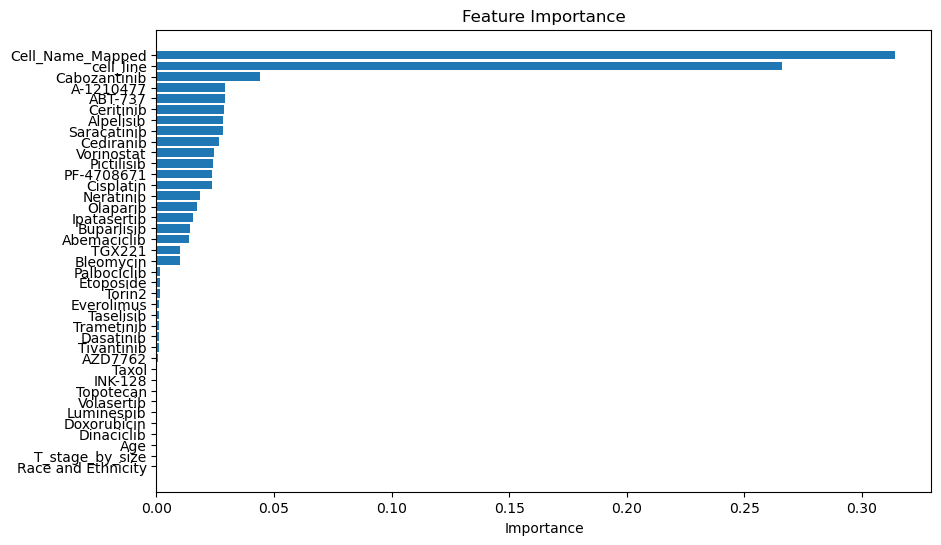

In [105]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


# LIMITATION NOTES TO EXPRESS TO AUDIENCE: 
### - We have only 1 IC50 value per cell line x drug. This means there is no variation in IC50 values per cell line x drug. This means demographic information has little affect on our results. 
### - CELL LINE IS A PROXY FOR THE PATIENT.
### - IF WE ASSUME THE CELL LINE REPRESENTS THE PATIENT, THEN PATIENT DEMOGRAPHICS ARE INFLUENCING THE IC50.
### - IC50 ACTS LIKE THE DOSAGE INFORMATION FOR THE PATIENT. 

### PERHAPS INCLUDE THE FOLLOWING FEATURES: BMI, MENOPAUSE STATUS

# New patient test:

In [ ]:
# Create a template with all zero values
new_patient = pd.DataFrame(columns=X.columns)
new_patient.loc[0] = 0  # initialize all features with 0

# Fill in actual values for the patient
new_patient.at[0, 'Age'] = 52  # example age
new_patient.at[0, 'Race and Ethnicity'] = 3  # assuming this is an integer-coded category
new_patient.at[0, 'cell_line'] = 5  # this should match a valid cell_line used during training

# Indicate which drug you're testing by setting the one-hot column to 1
new_patient.at[0, 'Buparlisib'] = 1  # for example

# Standardize Age using the same scaler used during training
new_patient[['Age']] = scaler.transform(new_patient[['Age']])

In [68]:
# List of non-drug columns and non-one-hot-encoded
non_drug_columns = ['Age', 'Race and Ethnicity', 'cell_line', 'Patient ID', 'T_stage_by_size', 'Survival Months', 'Cell Name', 'Small Molecule Name', 'EC50 (uM)', 'Cell_Name_Mapped']

drug_columns = [col for col in X.columns if col not in non_drug_columns]


# Get drug columns by excluding non-drug columns
drug_columns = [col for col in X.columns if col not in non_drug_columns]
results = []

# Loop through each drug and make a prediction
for drug in drug_columns:
    temp_input = new_patient.copy()
    temp_input[drug] = 1
    try:
        ec50 = model.predict(temp_input)[0]
        results.append((drug, ec50))
    except Exception as e:
        print(f"Error predicting for {drug}: {e}")

# Sort drugs by predicted EC50 (lower is better)
results = sorted(results, key=lambda x: x[1])

# Display top 5 recommended drugs
for drug, ec50 in results[:5]:
    print(f'{drug}: predicted EC50 = {ec50:.4f} µM')


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 co

Neratinib: predicted EC50 = 0.0911 µM
Olaparib: predicted EC50 = 0.4871 µM
Ipatasertib: predicted EC50 = 0.6020 µM
Patient ID_Breast_MRI_297: predicted EC50 = 1.1191 µM
Patient ID_MB-0215: predicted EC50 = 1.1191 µM


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
# Model to answer this question: “Given a patient and how effective a drug was (EC50), can we predict which drug it was?”

